<a href="https://colab.research.google.com/github/JosephHobbs9292/Voter-Classification-and-Feature-Importance/blob/main/RFH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Introduction
---

Model One - Kmeans model: The first model is an unsupervised learning model focused on the voters who registered Republican but voted for Hillary Clinton in the 2016 election. It's purpose is to divide those voters into similiar groupings with definable characteristics for futher understanding of voter preferences and behavior.

Model Two - Random Forest model: Model reintroduces all republican voter data and the target feature, voter preference. In addition, an analysis of feature importance is also conducted.

Model Three - Neural Network: Can the above features be used to predict who a person will vote for in a future election

Link to dataset: https://www.kaggle.com/datasets/democracy-fund/2016-voter-survey

## Setup
---

Importing libraries, loading in and creating dataframe, and displaying dataframe to review the imported data.

In [52]:
## Panda/Numpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Sanity
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Google Colab
from google.colab import files

# Keras
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout

# Sci-kit learn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, silhouette_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
## Shap
!pip install shap
import shap

## Lime
!pip install lime
from lime.lime_tabular import LimeTabularExplainer

In [2]:
## Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
## Creating Dataframe
df_voters = pd.read_csv("/content/VOTER_Survey_December16_Release1.csv")

In [4]:
## Displaying Dataframe
df_voters.head(10)

,case_identifier,PARTY_AGENDAS_rand_2016,presvote16post_2016,accurately_counted_2016,accurately_counted2_2016,fav_trump_2016,fav_obama_2016,fav_hrc_2016,fav_sanders_2016,PARTY_AGENDAS_R1_2016,...,econtrend_2016,Americatrend_2016,futuretrend_2016,wealth_2016,values_culture_2016,US_respect_2016,trustgovt_2016,trust_people_2016,helpful_people_2016,fair_people_2016
0,779,Republican Party,Hillary Clinton,Very confident,Not too confident,Very unfavorable,Very favorable,Very favorable,Very favorable,About the same,...,Getting better,Better,Don't know,Should be more evenly distributed,Holding steady,As respected as in the past,Some of the time,Don't know,People try to be helpful,Don't know
1,2108,Republican Party,Donald Trump,Very confident,Very confident,Very favorable,Very unfavorable,Very unfavorable,Very unfavorable,Much more,...,Getting worse,Better,Better than R's,Distribution is fair,Generally becoming rarer and less accepted,Less respected,Some of the time,Most people can be trusted,People try to be helpful,People would try to be fair
2,2597,Republican Party,Hillary Clinton,Not too confident,Not too confident,Very unfavorable,Very favorable,Very favorable,Somewhat favorable,About the same,...,Getting worse,Better,Better than R's,Should be more evenly distributed,Generally becoming rarer and less accepted,More respected,Some of the time,Can't be too careful in dealing with people,People are looking out for themselves,People would try to take advantage
3,4460,Republican Party,Donald Trump,Very confident,Very confident,Somewhat favorable,Somewhat unfavorable,Very unfavorable,Somewhat unfavorable,Somewhat more,...,About the same,Worse,Don't know,Distribution is fair,Generally becoming rarer and less accepted,As respected as in the past,Some of the time,Can't be too careful in dealing with people,People try to be helpful,People would try to take advantage
4,5903,Republican Party,Hillary Clinton,Very confident,Very confident,Very unfavorable,Very favorable,Somewhat favorable,Very favorable,Much less,...,Getting better,About the same,Better than R's,Should be more evenly distributed,Generally becoming rarer and less accepted,As respected as in the past,Some of the time,Most people can be trusted,People are looking out for themselves,People would try to be fair
5,6059,Republican Party,Donald Trump,Very confident,Very confident,Very favorable,Very unfavorable,Very unfavorable,Very unfavorable,Somewhat more,...,Getting worse,Worse,Worse than R's,Distribution is fair,Generally becoming rarer and less accepted,Less respected,Some of the time,Can't be too careful in dealing with people,People are looking out for themselves,People would try to take advantage
6,8048,Republican Party,Hillary Clinton,Very confident,Very confident,Very unfavorable,Very favorable,Somewhat favorable,Somewhat favorable,Much less,...,Getting better,About the same,Better than R's,Should be more evenly distributed,Generally becoming more widespread and accepted,Less respected,Some of the time,Most people can be trusted,People try to be helpful,People would try to be fair
7,13112,Republican Party,Hillary Clinton,Somewhat confident,Somewhat confident,Very unfavorable,Very favorable,Very favorable,Somewhat favorable,Somewhat less,...,Getting better,Better,Better than R's,Should be more evenly distributed,Generally becoming rarer and less accepted,Less respected,Some of the time,Can't be too careful in dealing with people,People are looking out for themselves,People would try to take advantage
8,14087,Republican Party,Hillary Clinton,Somewhat confident,Somewhat confident,Very unfavorable,Very favorable,Somewhat favorable,Very favorable,Somewhat less,...,Getting better,Worse,Worse than R's,Should be more evenly distributed,Generally becoming rarer and less accepted,Less respected,Some of the time,Most people can be trusted,People are looking out for themselves,People would try to take advantage
9,14474,Republican Party,Donald Trump,Not too confident,Somewhat confident,Som

In [5]:
## Displaying Dataframe info
df_voters.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3593 entries, 0 to 3592
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   case_identifier           3593 non-null   int64 
 1   PARTY_AGENDAS_rand_2016   3593 non-null   object
 2   presvote16post_2016       3593 non-null   object
 3   accurately_counted_2016   3590 non-null   object
 4   accurately_counted2_2016  3580 non-null   object
 5   fav_trump_2016            3577 non-null   object
 6   fav_obama_2016            3573 non-null   object
 7   fav_hrc_2016              3568 non-null   object
 8   fav_sanders_2016          3574 non-null   object
 9   PARTY_AGENDAS_R1_2016     3532 non-null   object
 10  PARTY_AGENDAS_R2_2016     3535 non-null   object
 11  PARTY_AGENDAS_R3_2016     3533 non-null   object
 12  PARTY_AGENDAS_R4_2016     3535 non-null   object
 13  PARTY_AGENDAS_R5_2016     3544 non-null   object
 14  PARTY_AGENDAS_R6_2016   

## Data Cleaning
---

Removing null values as they represent less than one percent of all rows and converting data to numeric datatype.

In [6]:
## Checking for null values
df_voters.isnull().sum()

case_identifier              0
PARTY_AGENDAS_rand_2016      0
presvote16post_2016          0
accurately_counted_2016      3
accurately_counted2_2016    13
fav_trump_2016              16
fav_obama_2016              20
fav_hrc_2016                25
fav_sanders_2016            19
PARTY_AGENDAS_R1_2016       61
PARTY_AGENDAS_R2_2016       58
PARTY_AGENDAS_R3_2016       60
PARTY_AGENDAS_R4_2016       58
PARTY_AGENDAS_R5_2016       49
PARTY_AGENDAS_R6_2016       57
PARTY_AGENDAS_R7_2016       66
PARTY_AGENDAS_R8_2016       66
PARTY_AGENDAS_R9_2016       60
PARTY_AGENDAS_R10_2016      62
PARTY_AGENDAS_R11_2016      52
PARTY_AGENDAS_R12_2016      52
track_2016                  44
persfinretro_2016            3
econtrend_2016              18
Americatrend_2016            8
futuretrend_2016             9
wealth_2016                 12
values_culture_2016          5
US_respect_2016             10
trustgovt_2016              23
trust_people_2016           22
helpful_people_2016         13
fair_peo

In [7]:
## Dropping null values
df_voters = df_voters.dropna()
df_voters.isnull().sum()

case_identifier             0
PARTY_AGENDAS_rand_2016     0
presvote16post_2016         0
accurately_counted_2016     0
accurately_counted2_2016    0
fav_trump_2016              0
fav_obama_2016              0
fav_hrc_2016                0
fav_sanders_2016            0
PARTY_AGENDAS_R1_2016       0
PARTY_AGENDAS_R2_2016       0
PARTY_AGENDAS_R3_2016       0
PARTY_AGENDAS_R4_2016       0
PARTY_AGENDAS_R5_2016       0
PARTY_AGENDAS_R6_2016       0
PARTY_AGENDAS_R7_2016       0
PARTY_AGENDAS_R8_2016       0
PARTY_AGENDAS_R9_2016       0
PARTY_AGENDAS_R10_2016      0
PARTY_AGENDAS_R11_2016      0
PARTY_AGENDAS_R12_2016      0
track_2016                  0
persfinretro_2016           0
econtrend_2016              0
Americatrend_2016           0
futuretrend_2016            0
wealth_2016                 0
values_culture_2016         0
US_respect_2016             0
trustgovt_2016              0
trust_people_2016           0
helpful_people_2016         0
fair_people_2016            0
dtype: int

In [8]:
## Creating loop to convert data in confidence columns from Likert scale to numerical values and also converting column to int datatype
columns_confidence = ["accurately_counted_2016", "accurately_counted2_2016"]
for x in columns_confidence:
  df_voters[x] = df_voters[x].replace(["Not at all confident", "Somewhat confident", "Not too confident", "Very confident"], [1,2,3,4])
  df_voters[x] = df_voters[x].astype("int64")



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
## Creating loop to convert data in favorability columns from Likert scale to numerical values and also converting column to int datatype
columns_favor = ["fav_trump_2016", "fav_obama_2016", "fav_hrc_2016", "fav_sanders_2016"]
for x in columns_favor:
  df_voters[x] = df_voters[x].replace(["Very unfavorable", "Somewhat unfavorable", "Don't know", "Somewhat favorable","Very favorable" ], [1,2,3,4,5])
  df_voters[x] = df_voters[x].astype("int64")
df_voters.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3210 entries, 0 to 3592
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   case_identifier           3210 non-null   int64 
 1   PARTY_AGENDAS_rand_2016   3210 non-null   object
 2   presvote16post_2016       3210 non-null   object
 3   accurately_counted_2016   3210 non-null   int64 
 4   accurately_counted2_2016  3210 non-null   int64 
 5   fav_trump_2016            3210 non-null   int64 
 6   fav_obama_2016            3210 non-null   int64 
 7   fav_hrc_2016              3210 non-null   int64 
 8   fav_sanders_2016          3210 non-null   int64 
 9   PARTY_AGENDAS_R1_2016     3210 non-null   object
 10  PARTY_AGENDAS_R2_2016     3210 non-null   object
 11  PARTY_AGENDAS_R3_2016     3210 non-null   object
 12  PARTY_AGENDAS_R4_2016     3210 non-null   object
 13  PARTY_AGENDAS_R5_2016     3210 non-null   object
 14  PARTY_AGENDAS_R6_2016   


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
## Creating loop to convert data in agenda columns from Likert scale to numerical values and also converting column to int datatype
columns_agenda = ["PARTY_AGENDAS_R1_2016", "PARTY_AGENDAS_R2_2016", "PARTY_AGENDAS_R3_2016", "PARTY_AGENDAS_R4_2016", "PARTY_AGENDAS_R5_2016", "PARTY_AGENDAS_R6_2016", "PARTY_AGENDAS_R7_2016", "PARTY_AGENDAS_R8_2016", "PARTY_AGENDAS_R9_2016", "PARTY_AGENDAS_R10_2016", "PARTY_AGENDAS_R11_2016", "PARTY_AGENDAS_R12_2016"]
for x in columns_agenda:
  df_voters[x] = df_voters[x].replace(["Much less", "Somewhat less", "About the same", "Somewhat more","Much more"], [1,2,3,4,5])
  df_voters[x] = df_voters[x].astype("int64")
df_voters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3210 entries, 0 to 3592
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   case_identifier           3210 non-null   int64 
 1   PARTY_AGENDAS_rand_2016   3210 non-null   object
 2   presvote16post_2016       3210 non-null   object
 3   accurately_counted_2016   3210 non-null   int64 
 4   accurately_counted2_2016  3210 non-null   int64 
 5   fav_trump_2016            3210 non-null   int64 
 6   fav_obama_2016            3210 non-null   int64 
 7   fav_hrc_2016              3210 non-null   int64 
 8   fav_sanders_2016          3210 non-null   int64 
 9   PARTY_AGENDAS_R1_2016     3210 non-null   int64 
 10  PARTY_AGENDAS_R2_2016     3210 non-null   int64 
 11  PARTY_AGENDAS_R3_2016     3210 non-null   int64 
 12  PARTY_AGENDAS_R4_2016     3210 non-null   int64 
 13  PARTY_AGENDAS_R5_2016     3210 non-null   int64 
 14  PARTY_AGENDAS_R6_2016   


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
## Changing values from Likert scale to numerical values and changing column to int datatype
df_voters["econtrend_2016"] = df_voters["econtrend_2016"].replace(["Getting worse", "Don't know", "About the same", "Getting better"], [1,2,3,4])
df_voters["econtrend_2016"] = df_voters["econtrend_2016"].astype("int64")


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
## Changing values from Likert scale to numerical values and changing column to int datatype
df_voters["track_2016"] = df_voters["track_2016"].replace(["Off on the wrong track", "Don't know", "Generally headed in the right direction"], [1,2,3])
df_voters["track_2016"] = df_voters["track_2016"].astype("int64")

In [13]:
## Changing values from Likert scale to numerical values and changing column to int datatype
df_voters["futuretrend_2016"] = df_voters["futuretrend_2016"].replace(["Worse than R's", "Don't know", "About the same as R's", "Better than R's"], [1,2,3,4])
df_voters["futuretrend_2016"] = df_voters["futuretrend_2016"].astype("int64")

In [14]:
## Changing values from Likert scale to numerical values and changing column to int datatype
df_voters["wealth_2016"] = df_voters["wealth_2016"].replace(["Should be more evenly distributed", "Don't know", "Distribution is fair"], [1,2,3])
df_voters["wealth_2016"] = df_voters["wealth_2016"].astype("int64")

In [15]:
## Changing values from Likert scale to numerical values and changing column to int datatype
df_voters["values_culture_2016"] = df_voters["values_culture_2016"].replace(["Generally becoming rarer and less accepted", "Don't know", "Holding steady", "Generally becoming more widespread and accepted"], [1,2,3,4])
df_voters["values_culture_2016"] = df_voters["values_culture_2016"].astype("int64")

In [16]:
## Changing values from Likert scale to numerical values and changing column to int datatype
df_voters["values_culture_2016"] = df_voters["values_culture_2016"].replace(["Less respected", "Don't know", "As respected as in the past", "More respected"], [1,2,3,4])
df_voters["values_culture_2016"] = df_voters["values_culture_2016"].astype("int64")

In [17]:
## Changing values from Likert scale to numerical values and changing column to int datatype
df_voters["trustgovt_2016"] = df_voters["trustgovt_2016"].replace(["Some of the time", "Most of the time", "Just about always"], [1,2,3])
df_voters["trustgovt_2016"] = df_voters["trustgovt_2016"].astype("int64")

In [18]:
## Changing values from Likert scale to numerical values and changing column to int datatype
df_voters["trust_people_2016"] = df_voters["trustgovt_2016"].replace(["Can't be too careful in dealing with people", "Don't know", "Most people can be trusted"], [1,2,3])
df_voters["trust_people_2016"] = df_voters["trustgovt_2016"].astype("int64")

In [19]:
## Changing values from Likert scale to numerical values and changing column to int datatype
df_voters["helpful_people_2016"] = df_voters["helpful_people_2016"].replace(["People are looking out for themselves", "Don't know", "People try to be helpful"], [1,2,3])
df_voters["helpful_people_2016"] = df_voters["helpful_people_2016"].astype("int64")

In [20]:
## Changing values from Likert scale to numerical values and changing column to int datatype
df_voters["fair_people_2016"] = df_voters["fair_people_2016"].replace(["People would try to take advantage", "Don't know", "People would try to be fair"], [1,2,3])
df_voters["fair_people_2016"] = df_voters["fair_people_2016"].astype("int64")

In [21]:
## Changing values from Likert scale to numerical values and changing column to int datatype
df_voters["persfinretro_2016"] = df_voters["persfinretro_2016"].replace(["Worse off financially", "Don't know", "About the same as now", "Better off financially"], [1,2,3,4])
df_voters["persfinretro_2016"] = df_voters["persfinretro_2016"].astype("int64")

In [22]:
## Changing values from Likert scale to numerical values and changing column to int datatype
df_voters["Americatrend_2016"] = df_voters["Americatrend_2016"].replace(["Worse", "Don't know", "About the same", "Better"], [1,2,3,4])
df_voters["Americatrend_2016"] = df_voters["Americatrend_2016"].astype("int64")

In [23]:
## Changing values from Likert scale to numerical values and changing column to int datatype
df_voters["US_respect_2016"] = df_voters["US_respect_2016"].replace(["Less respected", "Don't know", "As respected as in the past", "More respected"], [1,2,3,4])
df_voters["US_respect_2016"] = df_voters["US_respect_2016"].astype("int64")

In [24]:
df_voters["presvote16post_2016"] = df_voters["presvote16post_2016"].replace(["Hillary Clinton", "Donald Trump"], [1,2])
df_voters["presvote16post_2016"] = df_voters["presvote16post_2016"].astype("int64")

In [25]:
## Dropping unneeded columns
df_voters = df_voters.drop(columns = ["PARTY_AGENDAS_rand_2016"])

In [26]:
## Verifying all columns are all correct
df_voters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3210 entries, 0 to 3592
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   case_identifier           3210 non-null   int64
 1   presvote16post_2016       3210 non-null   int64
 2   accurately_counted_2016   3210 non-null   int64
 3   accurately_counted2_2016  3210 non-null   int64
 4   fav_trump_2016            3210 non-null   int64
 5   fav_obama_2016            3210 non-null   int64
 6   fav_hrc_2016              3210 non-null   int64
 7   fav_sanders_2016          3210 non-null   int64
 8   PARTY_AGENDAS_R1_2016     3210 non-null   int64
 9   PARTY_AGENDAS_R2_2016     3210 non-null   int64
 10  PARTY_AGENDAS_R3_2016     3210 non-null   int64
 11  PARTY_AGENDAS_R4_2016     3210 non-null   int64
 12  PARTY_AGENDAS_R5_2016     3210 non-null   int64
 13  PARTY_AGENDAS_R6_2016     3210 non-null   int64
 14  PARTY_AGENDAS_R7_2016     3210 non-null 

In [27]:
## Verifying all data is correct
df_voters.head(10)

,case_identifier,presvote16post_2016,accurately_counted_2016,accurately_counted2_2016,fav_trump_2016,fav_obama_2016,fav_hrc_2016,fav_sanders_2016,PARTY_AGENDAS_R1_2016,PARTY_AGENDAS_R2_2016,...,econtrend_2016,Americatrend_2016,futuretrend_2016,wealth_2016,values_culture_2016,US_respect_2016,trustgovt_2016,trust_people_2016,helpful_people_2016,fair_people_2016
0,779,1,4,3,1,5,5,5,3,4,...,4,4,2,1,3,3,1,1,3,2
1,2108,2,4,4,5,1,1,1,5,5,...,1,4,4,3,1,1,1,1,3,3
2,2597,1,3,3,1,5,5,4,3,4,...,1,4,4,1,1,4,1,1,1,1
3,4460,2,4,4,4,2,1,2,4,4,...,3,1,2,3,1,3,1,1,3,1
4,5903,1,4,4,1,5,4,5,1,5,...,4,3,4,1,1,3,1,1,1,3
5,6059,2,4,4,5,1,1,1,4,5,...,1,1,1,3,1,1,1,1,1,1
6,8048,1,4,4,1,5,4,4,1,5,...,4,3,4,1,4,1,1,1,3,3
7,13112,1,2,2,1,5,5,4,2,3,...,4,4,4,1,1,1,1,1,1,1
8,14087,1,2,2,1,5,4,5,2,5,...,4,1,1,1,1,1,1,1,1,1
9,14474,2,3,2,4,1,1,1,5,5,...,1,1,4,3,3,1,1,1,3,1


## Model One - Kmeans model
---

Discovering the best number of clusters to group by, creating a model to group the voters, then finding the characteristics that define each natural grouping.

1.   Group One (Name) -
2.   List item

means of each cluster in order to understand the relative differences between the clusters.

In [31]:
## Filtering out Republican voters who voted for HRC
df_hrc = df_voters[df_voters["presvote16post_2016"] == 1]
df_hrc.head()

,case_identifier,presvote16post_2016,accurately_counted_2016,accurately_counted2_2016,fav_trump_2016,fav_obama_2016,fav_hrc_2016,fav_sanders_2016,PARTY_AGENDAS_R1_2016,PARTY_AGENDAS_R2_2016,...,econtrend_2016,Americatrend_2016,futuretrend_2016,wealth_2016,values_culture_2016,US_respect_2016,trustgovt_2016,trust_people_2016,helpful_people_2016,fair_people_2016
0,779,1,4,3,1,5,5,5,3,4,...,4,4,2,1,3,3,1,1,3,2
2,2597,1,3,3,1,5,5,4,3,4,...,1,4,4,1,1,4,1,1,1,1
4,5903,1,4,4,1,5,4,5,1,5,...,4,3,4,1,1,3,1,1,1,3
6,8048,1,4,4,1,5,4,4,1,5,...,4,3,4,1,4,1,1,1,3,3
7,13112,1,2,2,1,5,5,4,2,3,...,4,4,4,1,1,1,1,1,1,1


In [32]:
## Scaling the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_hrc)

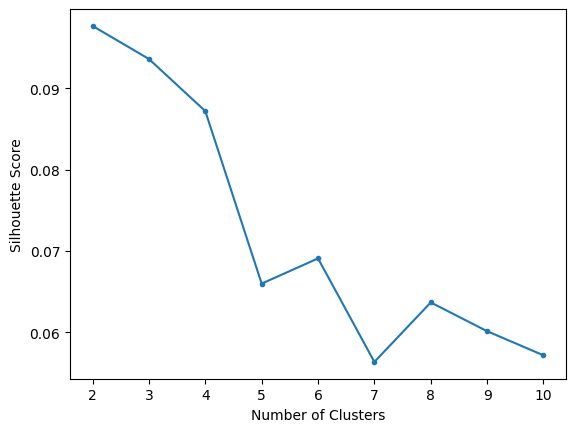

In [33]:
## Creating Silhouette Visualization
silhouette_scores = []
for i in range(2, 11):
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(df_scaled)
  silhouette_scores.append(silhouette_score(df_scaled, kmeans.labels_))
# Visualize scores
plt.plot(range(2, 11), silhouette_scores, marker = '.')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score');

In [36]:
## Creating model with 2 clusters
model = KMeans(n_clusters = 2, random_state = 42)
model.fit(df_scaled)
df_hrc["cluster"] = model.labels_


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [42]:
## Downloading dataframe with clusters
df_hrc.to_csv("clusters.csv")

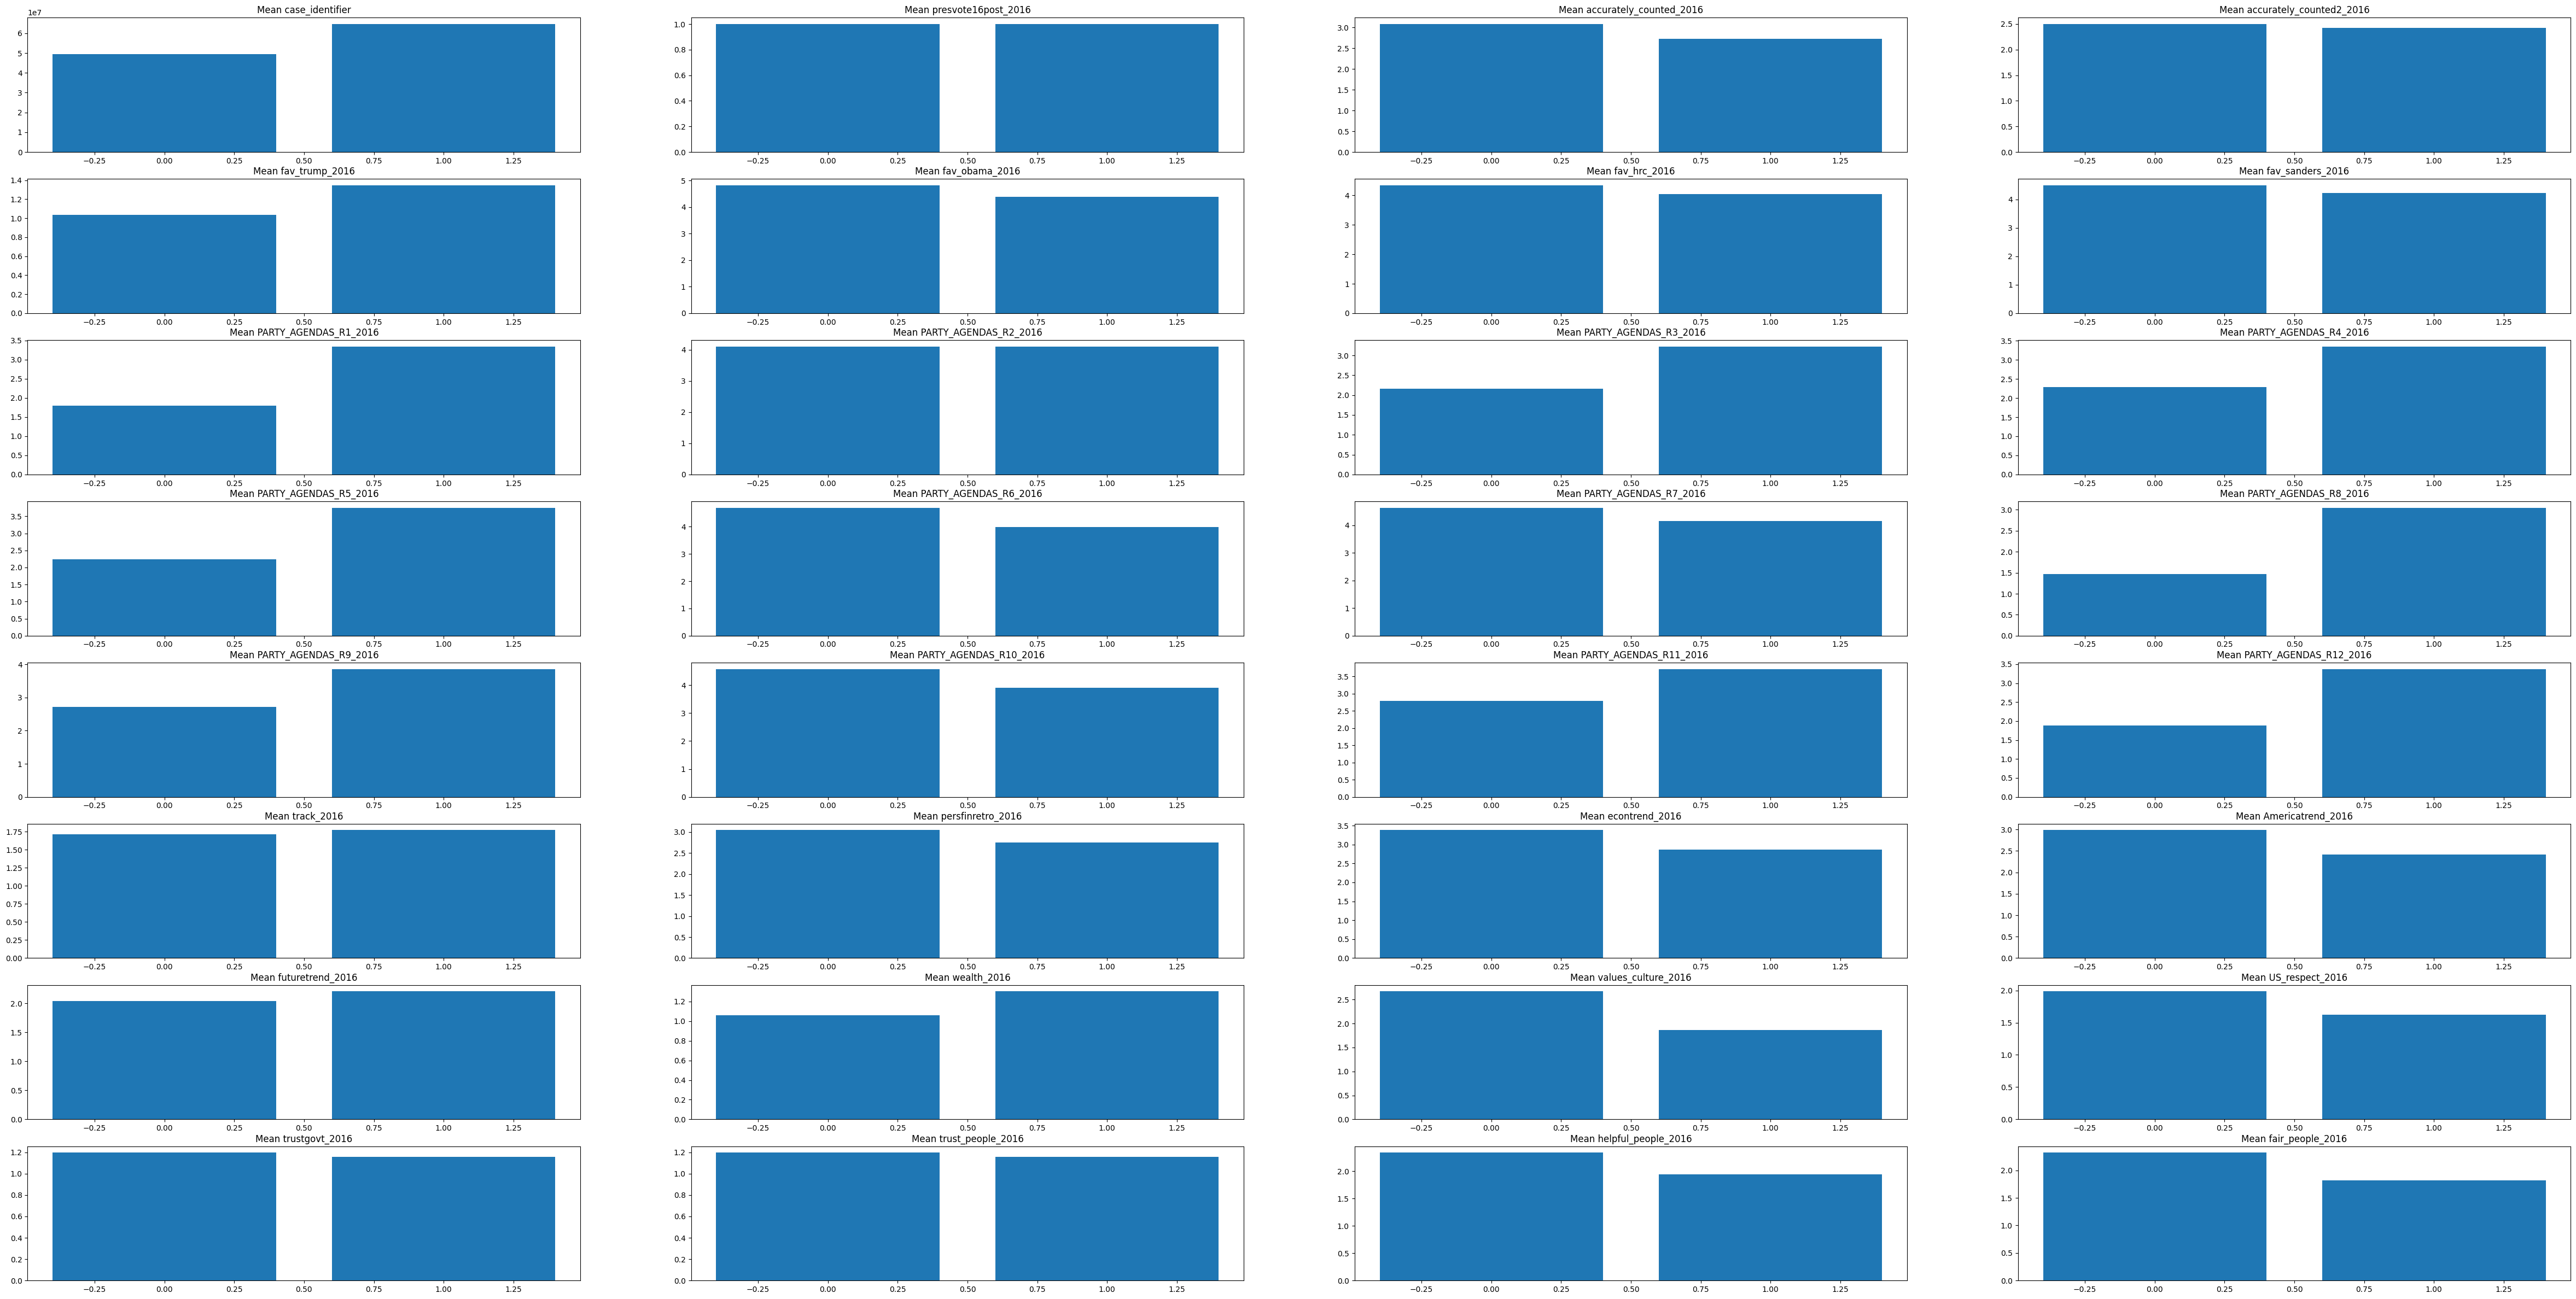

In [39]:
## Visualizing means to review differences in clusters
cluster_groups = df_hrc.groupby('cluster', as_index=False).mean()

# Visualize means
fig, axes = plt.subplots(8,4, figsize = (60, 30))
# fig is an array of dimensions 3,4.  axes.ravel() will flatten it to 12,1
axes = axes.ravel()
# Loop over columns and plot each in a separate figure, skip 'cluster' column
for i, col in enumerate(cluster_groups.columns[1:]):
  axes[i].bar(cluster_groups['cluster'], cluster_groups[col])
  axes[i].set_title(f'Mean {col}')

## Model Two: Random Forest
---


In [46]:
## Splitting the data
target = "presvote16post_2016"
X = df_voters.drop(columns = [target]).copy()
y = df_voters[target].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [53]:
## First iteration of model with default depth
rf = RandomForestRegressor(random_state = 42)
rf_pipe = make_pipeline(scaler, rf)
rf_pipe.fit(X_train, y_train)
rf_predictions = rf_pipe.predict(X_test)

rf_scores_train = rf_pipe.score(X_train, y_train)
rf_scores_test = rf_pipe.score(X_test, y_test)
print(rf_scores_train)
print(rf_scores_test)

0.991292186958425
0.9355337396709595


In [54]:
## finding best depth for rf model

est_depths = [estimator.get_depth() for estimator in rf.estimators_]
max(est_depths)

depths = range(1, max(est_depths))
scores = pd.DataFrame(index=depths, columns=['Test Score'])
for depth in depths:
   model = RandomForestRegressor(max_depth=depth)
   model.fit(X_train, y_train)
   scores.loc[depth, 'Train Score'] = model.score(X_train, y_train)
   scores.loc[depth, 'Test Score'] = model.score(X_test, y_test)
   scores.head()

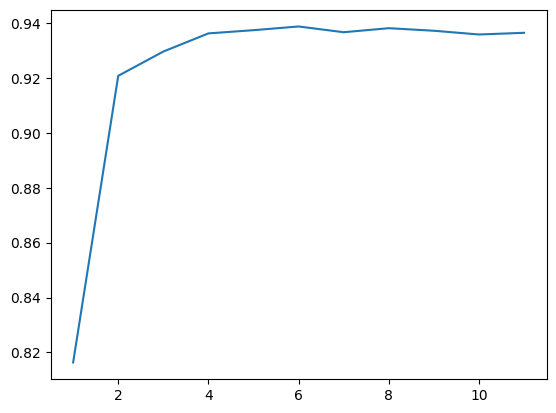

In [55]:
## Visualzing depth scores
plt.plot(scores['Test Score']);

In [56]:
## Showing best depth scores as a dataframe
sorted_scores = scores.sort_values(by='Test Score', ascending=False)
sorted_scores.head()


,Test Score,Train Score
6,0.938777,0.978266
8,0.938152,0.988246
5,0.93743,0.969709
9,0.937222,0.990084
7,0.936683,0.985248


In [57]:
## Tuned Random Forest Model
rf_tuned = RandomForestRegressor(max_depth = 6, random_state = 42)
rf_pipe_tuned = make_pipeline(scaler, rf_tuned)
rf_pipe_tuned.fit(X_train, y_train)
rf_predictions_tuned = rf_pipe_tuned.predict(X_test)

rf_scores_train_tuned = rf_pipe_tuned.score(X_train, y_train)
rf_scores_test_tuned = rf_pipe_tuned.score(X_test, y_test)
print(rf_scores_train_tuned)
print(rf_scores_test_tuned)

0.97955543670101
0.938099777326496
